In [102]:
#Import the librairies
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from mlxtend.plotting import plot_decision_regions
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score, 
                             precision_score, recall_score, f1_score, confusion_matrix)
from imblearn.combine import SMOTETomek
import random

#Import the dataset
data = 'flight_data_2024_sample.csv'
flight_df = pd.read_csv(data)
print(flight_df.head())

   year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0  2024      4            18            4  2024-04-18                MQ   
1  2024      1             1            1  2024-01-01                AA   
2  2024     12            12            4  2024-12-12                9E   
3  2024      4             8            1  2024-04-08                WN   
4  2024      2            16            5  2024-02-16                WN   

   op_carrier_fl_num origin       origin_city_name origin_state_nm  ...  \
0             3535.0    DFW  Dallas/Fort Worth, TX           Texas  ...   
1              148.0    CLT          Charlotte, NC  North Carolina  ...   
2             5440.0    CHA        Chattanooga, TN       Tennessee  ...   
3             1971.0    OMA              Omaha, NE        Nebraska  ...   
4              862.0    BWI          Baltimore, MD        Maryland  ...   

  diverted crs_elapsed_time actual_elapsed_time  air_time  distance  \
0        0            151.0

## Clean the Dataset

### Remove none important independent variables

In [103]:
print(flight_df.columns)

flight_df.drop(['taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
    'cancellation_code', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'], axis=1, inplace=True)
print(flight_df.columns)

Index(['year', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'op_unique_carrier', 'op_carrier_fl_num', 'origin', 'origin_city_name',
       'origin_state_nm', 'dest', 'dest_city_name', 'dest_state_nm',
       'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
       'cancelled', 'cancellation_code', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'distance', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'],
      dtype='object')
Index(['year', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'op_unique_carrier', 'op_carrier_fl_num', 'origin', 'origin_city_name',
       'origin_state_nm', 'dest', 'dest_city_name', 'dest_state_nm',
       'crs_dep_time', 'dep_time', 'dep_delay', 'cancelled', 'distance'],
      dtype='object')


### Remove cancelled flights

In [104]:
flight_df = flight_df[flight_df['cancelled'] == 0]

print(flight_df)

      year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0     2024      4            18            4  2024-04-18                MQ   
1     2024      1             1            1  2024-01-01                AA   
2     2024     12            12            4  2024-12-12                9E   
3     2024      4             8            1  2024-04-08                WN   
4     2024      2            16            5  2024-02-16                WN   
...    ...    ...           ...          ...         ...               ...   
9995  2024      1            16            2  2024-01-16                WN   
9996  2024      7             5            5  2024-07-05                AA   
9997  2024      2            28            3  2024-02-28                MQ   
9998  2024      2            18            7  2024-02-18                DL   
9999  2024      3             1            5  2024-03-01                G4   

      op_carrier_fl_num origin       origin_city_name origin_st

## Create new categories

In [105]:
flight_df['flight_delayed'] = (flight_df['dep_delay'] > 0).astype(int)
print(flight_df.head())

   year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0  2024      4            18            4  2024-04-18                MQ   
1  2024      1             1            1  2024-01-01                AA   
2  2024     12            12            4  2024-12-12                9E   
3  2024      4             8            1  2024-04-08                WN   
4  2024      2            16            5  2024-02-16                WN   

   op_carrier_fl_num origin       origin_city_name origin_state_nm dest  \
0             3535.0    DFW  Dallas/Fort Worth, TX           Texas  RAP   
1              148.0    CLT          Charlotte, NC  North Carolina  PHX   
2             5440.0    CHA        Chattanooga, TN       Tennessee  ATL   
3             1971.0    OMA              Omaha, NE        Nebraska  LAS   
4              862.0    BWI          Baltimore, MD        Maryland  MYR   

     dest_city_name   dest_state_nm  crs_dep_time  dep_time  dep_delay  \
0    Rapid City, SD    S

## Decision Tree

### Training the Model

In [71]:
# Train-validation-test split
train_df, temp_df = train_test_split(
    flight_df, test_size=0.40, random_state=42)
validation_df, test_df = train_test_split(
    temp_df, test_size=0.625, random_state=42)  # 0.625 of 0.40 = 0.25

print(f"Train: {train_df.shape}, Validation: {validation_df.shape}, Test: {test_df.shape}")

# Define features/target per split
xDT_train = train_df.drop("flight_delayed", axis=1)
yDT_train = train_df["flight_delayed"]
xDT_validation = validation_df.drop("flight_delayed", axis=1)
yDT_validation = validation_df["flight_delayed"]
xDT_test = test_df.drop("flight_delayed", axis=1)
yDT_test = test_df["flight_delayed"]

# Encode the categorical columns to keep
categorical_cols = ['op_unique_carrier', 'origin', 'dest']
for col in categorical_cols:
    # Fit on all data combined (to ensure consistency across splits)
    all_values = pd.concat([xDT_train[col], xDT_validation[col], xDT_test[col]]).astype(str)
    le = LabelEncoder()
    le.fit(all_values)
    
    # Transform each set
    xDT_train[col] = le.transform(xDT_train[col].astype(str))
    xDT_validation[col] = le.transform(xDT_validation[col].astype(str))
    xDT_test[col] = le.transform(xDT_test[col].astype(str))

# Drop object columns and fl_date
columns_to_drop = ['fl_date', 'origin_city_name', 'origin_state_nm', 'dest_city_name', 
                   'dest_state_nm', 'dep_delay', 'crs_dep_time', 'op_carrier_fl_num']
xDT_train = xDT_train.drop(columns_to_drop, axis=1)
xDT_validation = xDT_validation.drop(columns_to_drop, axis=1)
xDT_test = xDT_test.drop(columns_to_drop, axis=1)

Train: (5926, 19), Validation: (1482, 19), Test: (2470, 19)


#### Cross Validation

In [72]:
# Import a Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
# Import the GridSearchCV class
from sklearn.model_selection import GridSearchCV
# Import the random module
import random

smotetomek = SMOTETomek(random_state=42)
xDT_train, yDT_train = smotetomek.fit_resample(xDT_train, yDT_train)

print(f"\nAfter SMOTETomek:")
print(f"Training set class distribution:\n{yDT_train.value_counts()}")
print(f"Validation set class distribution:\n{yDT_validation.value_counts()}")
print(f"Test set class distribution:\n{yDT_test.value_counts()}")

# Create a Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 10, 1),
    'min_samples_leaf': [5, 8, 10],
    'min_samples_split': [5, 10, 25]
}

gs = GridSearchCV(estimator=dt,
                  param_grid=param_grid, 
                  cv=5, 
                  return_train_score=True,
                  scoring='roc_auc',
                  n_jobs=-1, 
                  verbose=0)

random.seed(42)
gs.fit(xDT_train, yDT_train)
mDT_cart = gs.best_estimator_

print("\nBest hyperparameters:", gs.best_params_)


After SMOTETomek:
Training set class distribution:
flight_delayed
1    3315
0    3315
Name: count, dtype: int64
Validation set class distribution:
flight_delayed
0    935
1    547
Name: count, dtype: int64
Test set class distribution:
flight_delayed
0    1528
1     942
Name: count, dtype: int64

Best hyperparameters: {'criterion': 'gini', 'max_depth': np.int64(9), 'min_samples_leaf': 10, 'min_samples_split': 5}


#### Plotting the Decision Tree

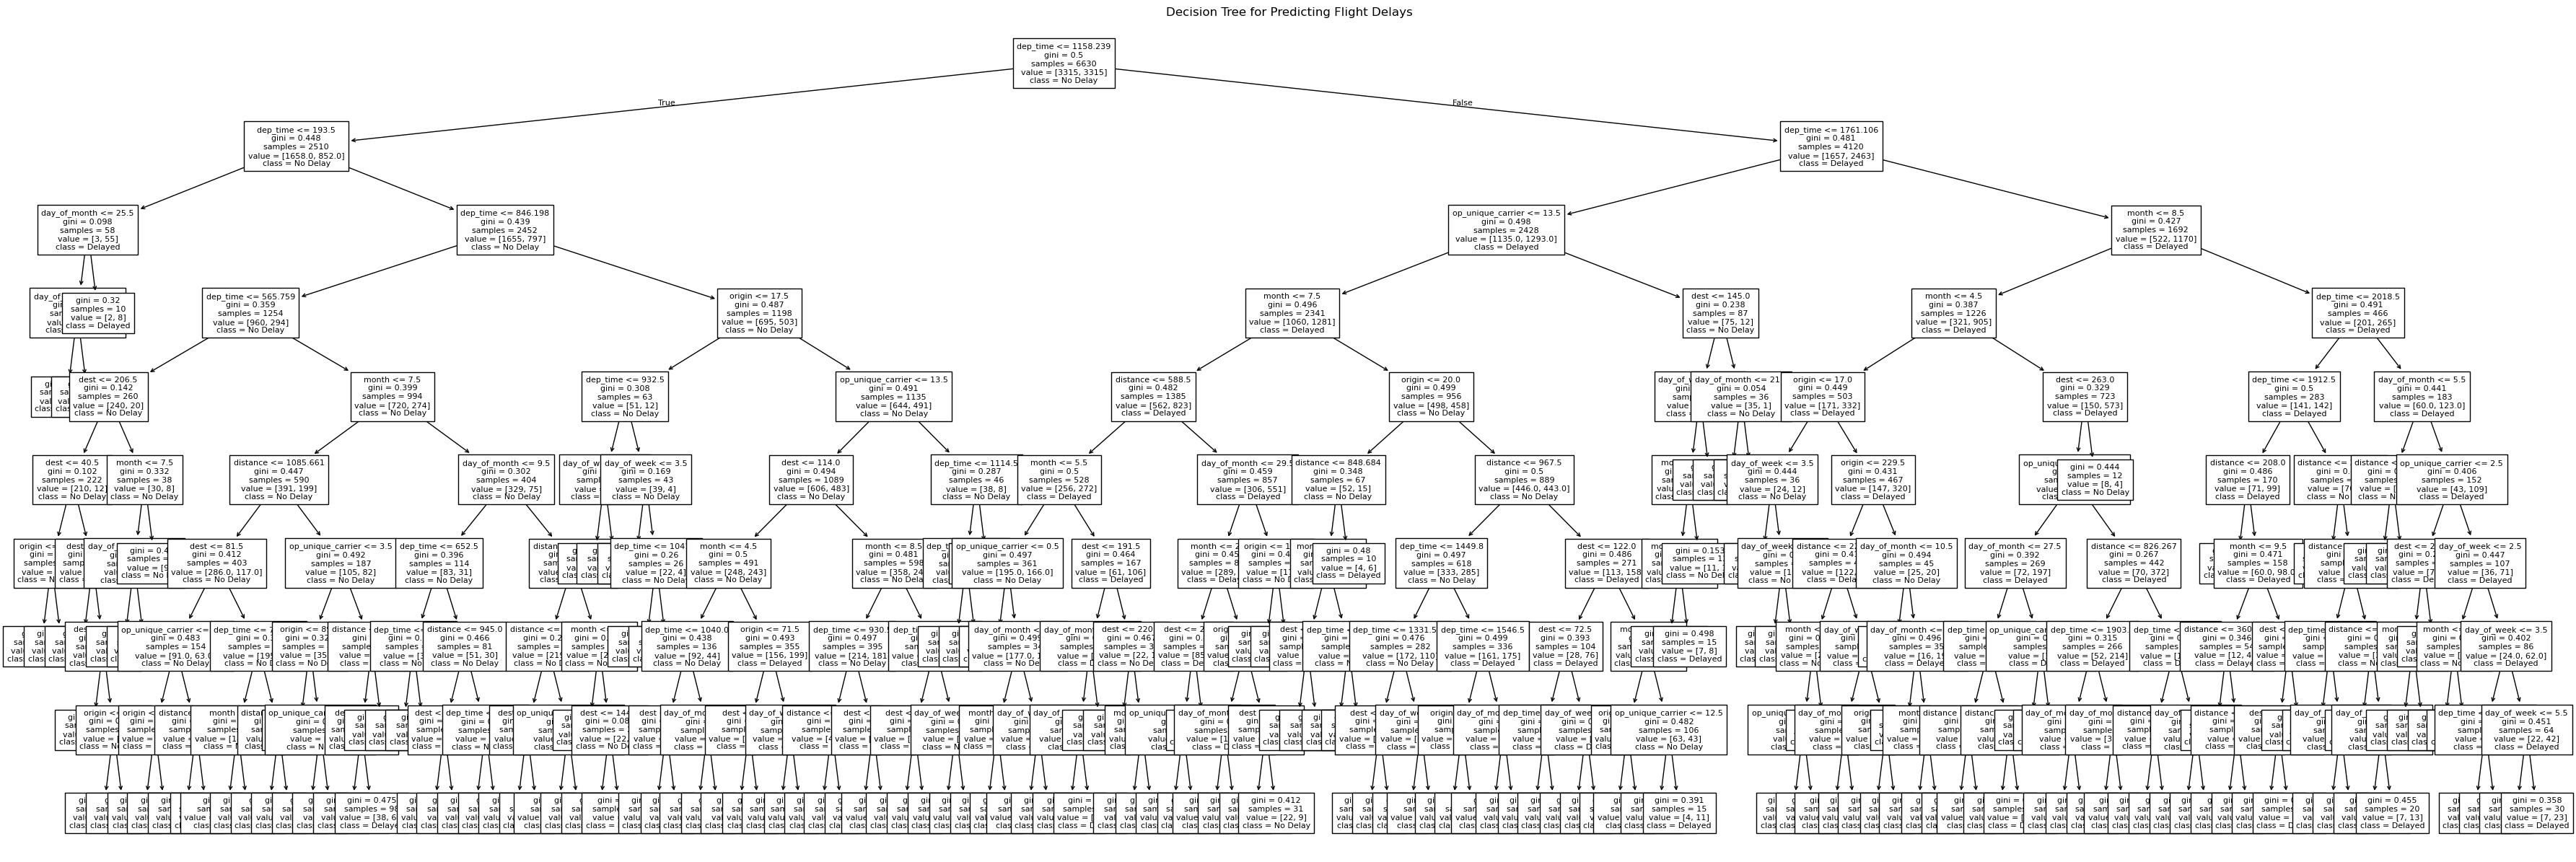

In [73]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(45, 15), dpi=100)

plot_tree(
    mDT_cart,                           
    feature_names=xDT_train.columns,
    class_names=['No Delay', 'Delayed'],
    filled=False,
    fontsize=8
)
plt.title("Decision Tree for Predicting Flight Delays")
plt.savefig("decision_tree_flight_delay.png", bbox_inches='tight', dpi=100)
plt.show()


#### Evaluating the Model

Training ROC AUC score: 0.8084482754698352
Testing ROC AUC score: 0.6228667839397073


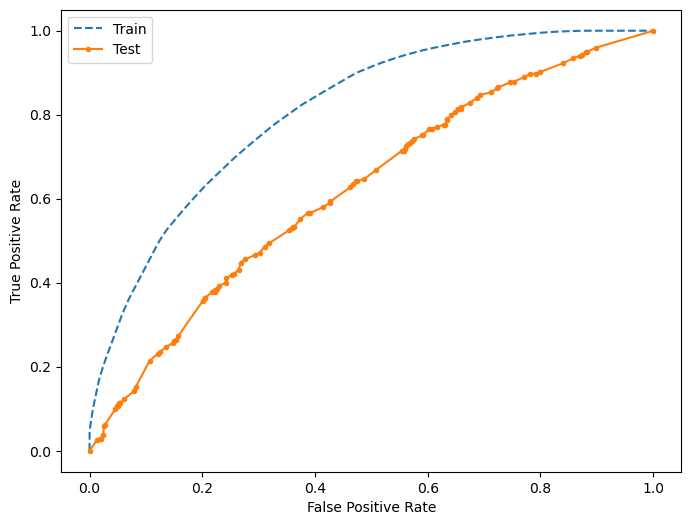

In [78]:
train_pred = mDT_cart.predict_proba(xDT_train)[:,1]
test_pred = mDT_cart.predict_proba(xDT_test)[:,1]

from sklearn.metrics import roc_auc_score, roc_curve
# Calculate the ROC AUC score for the training and testing sets
train_auc = roc_auc_score(yDT_train, train_pred)
test_auc = roc_auc_score(yDT_test, test_pred)
print("Training ROC AUC score:", train_auc)
print("Testing ROC AUC score:", test_auc)
# Plot the ROC curve for the training and testing sets
fpr_train, tpr_train, _ = roc_curve(yDT_train, train_pred)
fpr_test, tpr_test, _ = roc_curve(yDT_test, test_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, linestyle='--', label='Train')
plt.plot(fpr_test, tpr_test, marker='.', label='Test')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#### Classification Evaluation Function

In [133]:
def classification_evaluation_dt(model, X_train, y_train, X_validation, y_validation, 
                                 X_test, y_test, threshold=0.5):
    
    #Evaluate Decision Tree model on train, validation, and test sets.
    
    
    train_pred = model.predict_proba(X_train)[:, 1]
    validation_pred = model.predict_proba(X_validation)[:, 1]
    test_pred = model.predict_proba(X_test)[:, 1]
    
    # ROC AUC Scores
    train_auc = roc_auc_score(y_train, train_pred)
    validation_auc = roc_auc_score(y_validation, validation_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    
    # ROC Curves
    fpr_train, tpr_train, _ = roc_curve(y_train, train_pred)
    fpr_validation, tpr_validation, _ = roc_curve(y_validation, validation_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, test_pred)

    # Plot ROC Curves
    plt.figure(figsize=(10, 7))
    plt.plot(fpr_train, tpr_train, linestyle='--', label=f'Train (AUC: {train_auc:.3f})')
    plt.plot(fpr_validation, tpr_validation, linestyle='-.', label=f'Validation (AUC: {validation_auc:.3f})')
    plt.plot(fpr_test, tpr_test, marker='.', label=f'Test (AUC: {test_auc:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Decision Tree')
    plt.legend()
    plt.show()

    # Print Metrics
    print("DECISION TREE - CLASSIFICATION EVALUATION")

    print("\nROC AUC Scores")
    print(f"Train ROC AUC:       {train_auc:.3f}")
    print(f"Validation ROC AUC:  {validation_auc:.3f}")
    print(f"Test ROC AUC:        {test_auc:.3f}")
    
    print("\nAccuracy")
    print(f"Train Accuracy:      {accuracy_score(y_train, train_pred > threshold):.3f}")
    print(f"Validation Accuracy: {accuracy_score(y_validation, validation_pred > threshold):.3f}")
    print(f"Test Accuracy:       {accuracy_score(y_test, test_pred > threshold):.3f}")
    
    print("\nPrecision")
    print(f"Train Precision:     {precision_score(y_train, train_pred > threshold):.3f}")
    print(f"Validation Precision:{precision_score(y_validation, validation_pred > threshold):.3f}")
    print(f"Test Precision:      {precision_score(y_test, test_pred > threshold):.3f}")
    
    print("\nRecall")
    print(f"Train Recall:        {recall_score(y_train, train_pred > threshold):.3f}")
    print(f"Validation Recall:   {recall_score(y_validation, validation_pred > threshold):.3f}")
    print(f"Test Recall:         {recall_score(y_test, test_pred > threshold):.3f}")
    
    print("\nF1 Score")
    print(f"Train F1 Score:      {f1_score(y_train, train_pred > threshold):.3f}")
    print(f"Validation F1 Score: {f1_score(y_validation, validation_pred > threshold):.3f}")
    print(f"Test F1 Score:       {f1_score(y_test, test_pred > threshold):.3f}")
    

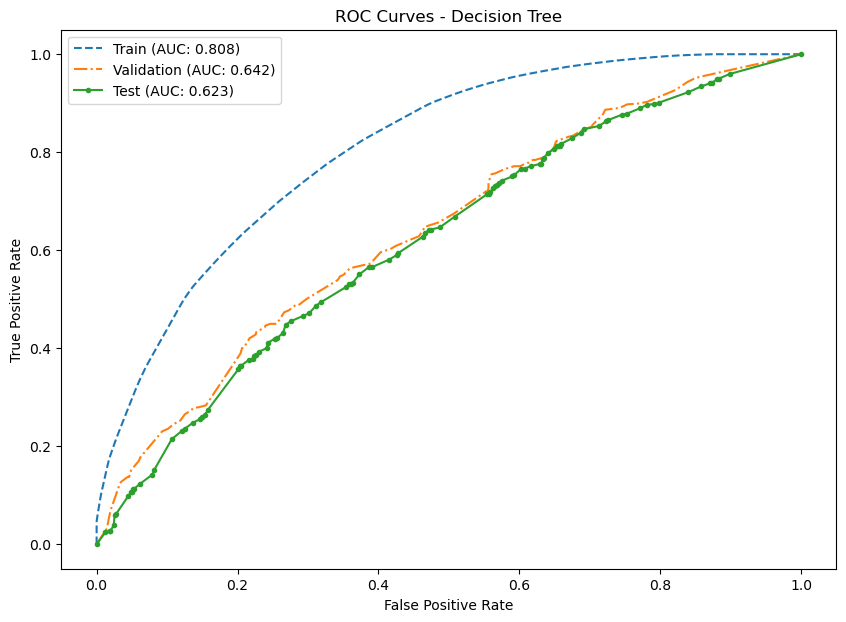

DECISION TREE - CLASSIFICATION EVALUATION

ROC AUC Scores
Train ROC AUC:       0.808
Validation ROC AUC:  0.642
Test ROC AUC:        0.623

Accuracy
Train Accuracy:      0.725
Validation Accuracy: 0.588
Test Accuracy:       0.581

Precision
Train Precision:     0.702
Validation Precision:0.456
Test Precision:      0.461

Recall
Train Recall:        0.781
Validation Recall:   0.609
Test Recall:         0.593

F1 Score
Train F1 Score:      0.739
Validation F1 Score: 0.522
Test F1 Score:       0.519


In [134]:
classification_evaluation_dt(mDT_cart, xDT_train, yDT_train, xDT_validation, yDT_validation, 
                             xDT_test, yDT_test, threshold=0.5)


## Gradient Boosting Classifier

### Training the Model

In [79]:
# train-validation-test split
train_df, temp_df = train_test_split(
    flight_df, test_size=0.40, random_state=42)
validation_df, test_df = train_test_split(
    temp_df, test_size=0.625, random_state=42)  # 0.625 of 0.40 = 0.25

print(f"Train: {train_df.shape}, Validation: {validation_df.shape}, Test: {test_df.shape}")

xGB_train = train_df.drop("flight_delayed", axis=1)
yGB_train = train_df["flight_delayed"]
xGB_validation = validation_df.drop("flight_delayed", axis=1)
yGB_validation = validation_df["flight_delayed"]
xGB_test = test_df.drop("flight_delayed", axis=1)
yGB_test = test_df["flight_delayed"]

categorical_cols = ['op_unique_carrier', 'origin', 'dest']
for col in categorical_cols:
    # Fit on all data combined (to ensure consistency across splits)
    all_values = pd.concat([xGB_train[col], xGB_validation[col], xGB_test[col]]).astype(str)
    le = LabelEncoder()
    le.fit(all_values)
    
    # Transform each set
    xGB_train[col] = le.transform(xGB_train[col].astype(str))
    xGB_validation[col] = le.transform(xGB_validation[col].astype(str))
    xGB_test[col] = le.transform(xGB_test[col].astype(str))

columns_to_drop = ['fl_date', 'origin_city_name', 'origin_state_nm', 'dest_city_name', 
                   'dest_state_nm', 'dep_delay', 'crs_dep_time', 'op_carrier_fl_num']
xGB_train = xGB_train.drop(columns_to_drop, axis=1)
xGB_validation = xGB_validation.drop(columns_to_drop, axis=1)
xGB_test = xGB_test.drop(columns_to_drop, axis=1)

smotetomek = SMOTETomek(random_state=42)
xGB_train, yGB_train = smotetomek.fit_resample(xGB_train, yGB_train)

print(f"\nAfter SMOTETomek:")
print(f"Training set class distribution:\n{yGB_train.value_counts()}")
print(f"Validation set class distribution:\n{yGB_validation.value_counts()}")
print(f"Test set class distribution:\n{yGB_test.value_counts()}")

Train: (5926, 19), Validation: (1482, 19), Test: (2470, 19)

After SMOTETomek:
Training set class distribution:
flight_delayed
1    3315
0    3315
Name: count, dtype: int64
Validation set class distribution:
flight_delayed
0    935
1    547
Name: count, dtype: int64
Test set class distribution:
flight_delayed
0    1528
1     942
Name: count, dtype: int64


In [80]:
from sklearn.ensemble import GradientBoostingClassifier
# Create the Random Forest Classifier
gb = GradientBoostingClassifier(random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': np.arange(3, 10, 1),      
    'min_samples_leaf': [0.01, 0.02],
    'max_features': [0.3, 0.5, 0.8, 'sqrt', 'log2']
}
# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)
# Fit the grid search on the training data
random.seed(42)
grid_search.fit(xGB_train, yGB_train)
# Get the best model from the grid search
mGB_best = grid_search.best_estimator_
# Display the best hyperparameters
print("\nBest hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits

Best hyperparameters: {'max_depth': np.int64(9), 'max_features': 0.8, 'min_samples_leaf': 0.01, 'n_estimators': 300}


#### Features Importance

/var/folders/ls/9r4q2dwx4y7dw37gy3hqq3300000gn/T/ipykernel_37827/3739033677.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances_gb.head(10), palette='flare')


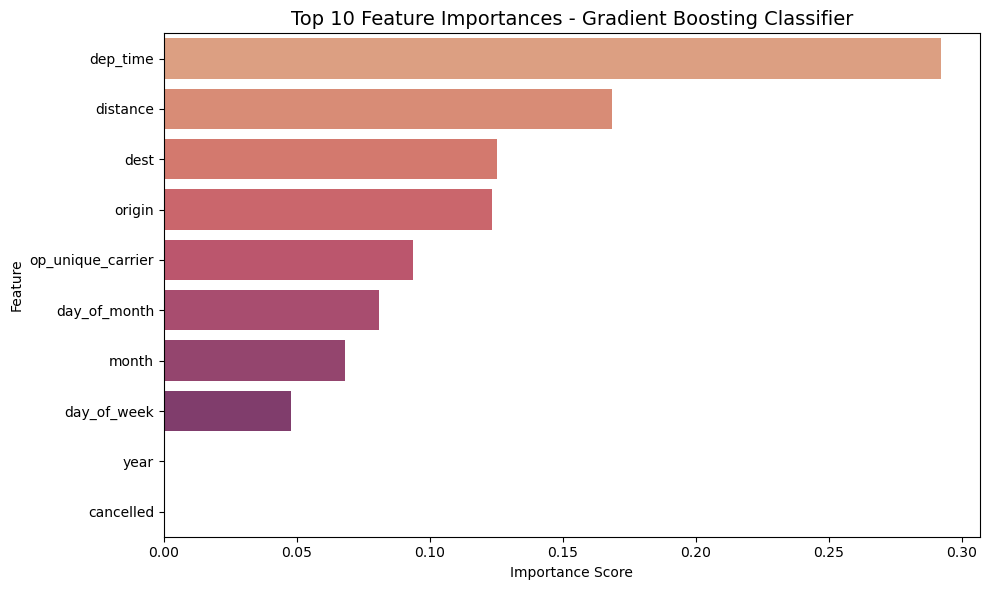


Top 3 Most Important Predictors:
    Feature  Importance
7  dep_time    0.292258
9  distance    0.168461
6      dest    0.125414


In [81]:
importances = mGB_best.feature_importances_
feature_importances_gb = pd.DataFrame({
    'Feature': xGB_train.columns,
    'Importance': importances
})
feature_importances_gb = feature_importances_gb.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_gb.head(10), palette='flare')
plt.title('Top 10 Feature Importances - Gradient Boosting Classifier', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 3 Most Important Predictors:")
print(feature_importances_gb.head(3))

#### Confusion Matrix

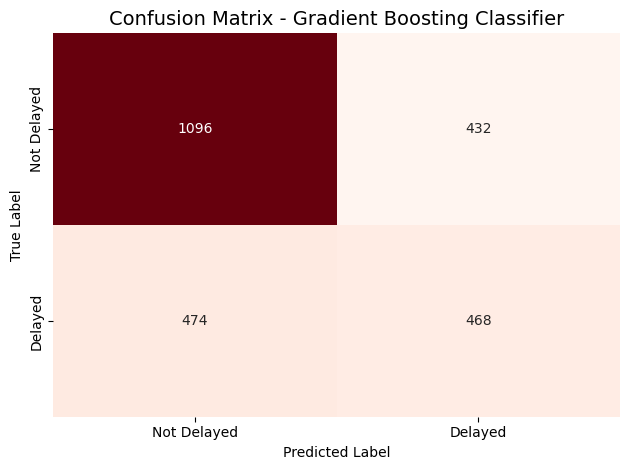


Classification Report (Test Set):
              precision    recall  f1-score   support

 Not Delayed       0.70      0.72      0.71      1528
     Delayed       0.52      0.50      0.51       942

    accuracy                           0.63      2470
   macro avg       0.61      0.61      0.61      2470
weighted avg       0.63      0.63      0.63      2470



In [82]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test set
y_pred_gb = mGB_best.predict(xGB_test)

# Create confusion matrix
cm = confusion_matrix(yGB_test, y_pred_gb)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['Not Delayed', 'Delayed'],
            yticklabels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix - Gradient Boosting Classifier', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report (Test Set):")
print(classification_report(yGB_test, y_pred_gb, target_names=['Not Delayed', 'Delayed']))


#### Classification Evaluation Function

In [131]:
def classification_evaluation_gb(model, X_train, y_train, X_validation, y_validation, 
                                 X_test, y_test, threshold=0.5):

    #Evaluate Gradient Boosting model on train, validation, and test sets.
    
    train_pred = model.predict_proba(X_train)[:, 1]
    validation_pred = model.predict_proba(X_validation)[:, 1]
    test_pred = model.predict_proba(X_test)[:, 1]
    
    # ROC AUC Scores
    train_auc = roc_auc_score(y_train, train_pred)
    validation_auc = roc_auc_score(y_validation, validation_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    
    # ROC Curves
    fpr_train, tpr_train, _ = roc_curve(y_train, train_pred)
    fpr_validation, tpr_validation, _ = roc_curve(y_validation, validation_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, test_pred)

    # Plot ROC Curves
    plt.figure(figsize=(10, 7))
    plt.plot(fpr_train, tpr_train, linestyle='--', label=f'Train (AUC: {train_auc:.3f})')
    plt.plot(fpr_validation, tpr_validation, linestyle='-.', label=f'Validation (AUC: {validation_auc:.3f})')
    plt.plot(fpr_test, tpr_test, marker='.', label=f'Test (AUC: {test_auc:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Gradient Boosting Classifier')
    plt.legend()
    plt.show()

    # Print Metrics
    print("GRADIENT BOOSTING - CLASSIFICATION EVALUATION")
    
    print("\nROC AUC Scores")
    print(f"Train ROC AUC:       {train_auc:.3f}")
    print(f"Validation ROC AUC:  {validation_auc:.3f}")
    print(f"Test ROC AUC:        {test_auc:.3f}")
    
    print("\nAccuracy")
    print(f"Train Accuracy:      {accuracy_score(y_train, train_pred > threshold):.3f}")
    print(f"Validation Accuracy: {accuracy_score(y_validation, validation_pred > threshold):.3f}")
    print(f"Test Accuracy:       {accuracy_score(y_test, test_pred > threshold):.3f}")
    
    print("\nPrecision")
    print(f"Train Precision:     {precision_score(y_train, train_pred > threshold):.3f}")
    print(f"Validation Precision:{precision_score(y_validation, validation_pred > threshold):.3f}")
    print(f"Test Precision:      {precision_score(y_test, test_pred > threshold):.3f}")
    
    print("\nRecall")
    print(f"Train Recall:        {recall_score(y_train, train_pred > threshold):.3f}")
    print(f"Validation Recall:   {recall_score(y_validation, validation_pred > threshold):.3f}")
    print(f"Test Recall:         {recall_score(y_test, test_pred > threshold):.3f}")
    
    print("\nF1 Score")
    print(f"Train F1 Score:      {f1_score(y_train, train_pred > threshold):.3f}")
    print(f"Validation F1 Score: {f1_score(y_validation, validation_pred > threshold):.3f}")
    print(f"Test F1 Score:       {f1_score(y_test, test_pred > threshold):.3f}")
    

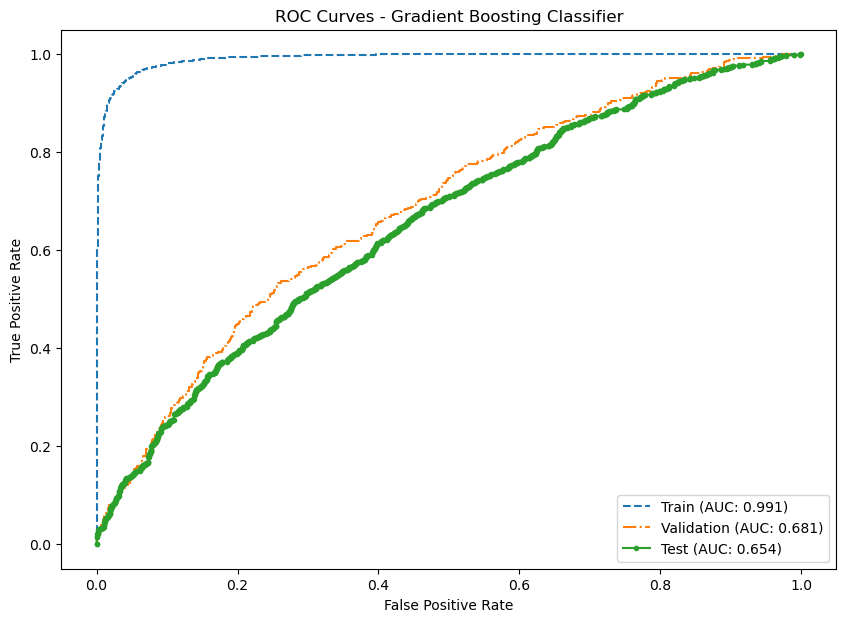

GRADIENT BOOSTING - CLASSIFICATION EVALUATION

ROC AUC Scores
Train ROC AUC:       0.991
Validation ROC AUC:  0.681
Test ROC AUC:        0.654

Accuracy
Train Accuracy:      0.952
Validation Accuracy: 0.662
Test Accuracy:       0.633

Precision
Train Precision:     0.949
Validation Precision:0.544
Test Precision:      0.520

Recall
Train Recall:        0.954
Validation Recall:   0.521
Test Recall:         0.497

F1 Score
Train F1 Score:      0.952
Validation F1 Score: 0.532
Test F1 Score:       0.508


In [132]:
classification_evaluation_gb(mGB_best, xGB_train, yGB_train, xGB_validation, yGB_validation, 
                             xGB_test, yGB_test, threshold=0.5)

## Random Forest

In [106]:
from sklearn.ensemble import RandomForestClassifier

#Split the data into training sets
rain_df, temp_df = train_test_split(
    flight_df, test_size=0.40, random_state=42)

#Split the data into test and validation sets
validation_df, test_df = train_test_split(
    temp_df, test_size=0.625, random_state=42)

#Print the shapes
print(f"Train: {train_df.shape}, Validation: {validation_df.shape}, Test: {test_df.shape}")

# Separate predictors (X) and target (y)
xRF_train = train_df.drop("flight_delayed", axis=1)
yRF_train = train_df["flight_delayed"]
xRF_validation = validation_df.drop("flight_delayed", axis=1)
yRF_validation = validation_df["flight_delayed"]
xRF_test = test_df.drop("flight_delayed", axis=1)
yRF_test = test_df["flight_delayed"]

# Encode the categorical columns you want to keep

categorical_cols = ['op_unique_carrier', 'origin', 'dest']
for col in categorical_cols:
    # Fit on all data combined (to ensure consistency across splits)
    all_values = pd.concat([xRF_train[col], xRF_validation[col], xRF_test[col]]).astype(str)
    le = LabelEncoder()
    le.fit(all_values)
    
    # Transform each set
    xRF_train[col] = le.transform(xRF_train[col].astype(str))
    xRF_validation[col] = le.transform(xRF_validation[col].astype(str))
    xRF_test[col] = le.transform(xRF_test[col].astype(str))


# Drop object columns and fl_date
columns_to_drop = ['fl_date', 'origin_city_name', 'origin_state_nm', 'dest_city_name', 
                   'dest_state_nm', 'dep_delay', 'crs_dep_time', 'op_carrier_fl_num']
xRF_train = xRF_train.drop(columns_to_drop, axis=1)
xRF_validation = xRF_validation.drop(columns_to_drop, axis=1)
xRF_test = xRF_test.drop(columns_to_drop, axis=1)

# Apply Smotetomek
smotetomek = SMOTETomek(random_state=42)
xRF_train, yRF_train = smotetomek.fit_resample(xRF_train, yRF_train)

print(f"\nAfter SMOTETomek:")
print(f"Training set class distribution:\n{yRF_train.value_counts()}")
print(f"Validation set class distribution:\n{yRF_validation.value_counts()}")
print(f"Test set class distribution:\n{yRF_test.value_counts()}")

# Create the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': np.arange(3, 10, 1),      
    'min_samples_leaf': [0.01, 0.02],
    'max_features': [0.3, 0.5, 0.8, 'sqrt', 'log2']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Fit the grid search on the training data
random.seed(42)
grid_search.fit(xRF_train, yRF_train)

# Get the best model from the grid search
mRF_best = grid_search.best_estimator_

# Display the best hyperparameters
print("\nBest hyperparameters:", grid_search.best_params_)

Train: (5926, 19), Validation: (1482, 19), Test: (2470, 19)

After SMOTETomek:
Training set class distribution:
flight_delayed
1    3315
0    3315
Name: count, dtype: int64
Validation set class distribution:
flight_delayed
0    935
1    547
Name: count, dtype: int64
Test set class distribution:
flight_delayed
0    1528
1     942
Name: count, dtype: int64
Fitting 5 folds for each of 210 candidates, totalling 1050 fits

Best hyperparameters: {'max_depth': np.int64(9), 'max_features': 0.3, 'min_samples_leaf': 0.01, 'n_estimators': 300}


/var/folders/ls/9r4q2dwx4y7dw37gy3hqq3300000gn/T/ipykernel_37827/2395369382.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances_rf.head(10), palette='crest')


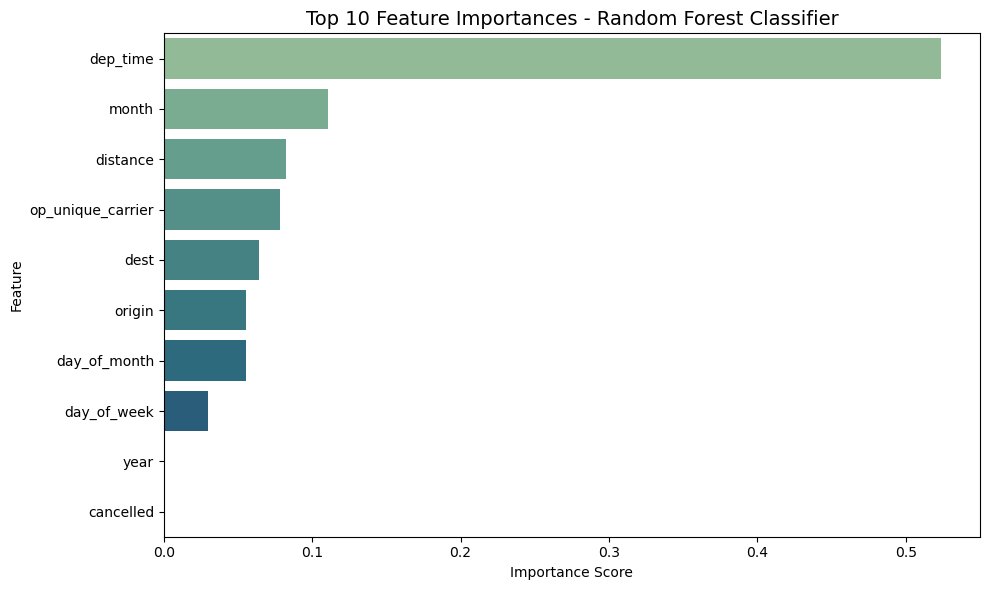


Top 3 Most Important Predictors:
    Feature  Importance
7  dep_time    0.523817
1     month    0.110740
9  distance    0.082193


In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get feature importances from the tuned Random Forest model
importances = mRF_best.feature_importances_

# Create a DataFrame for visualization
feature_importances_rf = pd.DataFrame({
    'Feature': xRF_train.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importances_rf = feature_importances_rf.sort_values(by='Importance', ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_rf.head(10), palette='crest')
plt.title('Top 10 Feature Importances - Random Forest Classifier', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Display the top 3 predictors
print("\nTop 3 Most Important Predictors:")
print(feature_importances_rf.head(3))


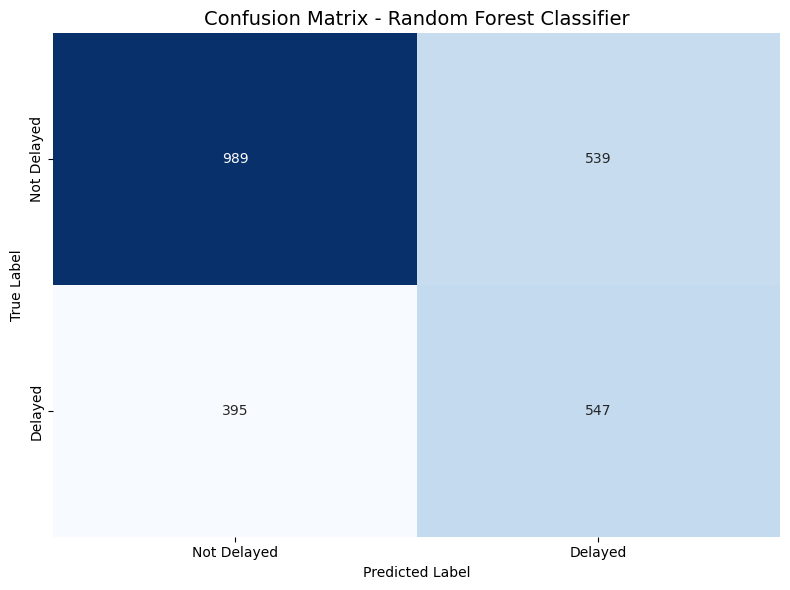


Classification Report (Test Set):
              precision    recall  f1-score   support

 Not Delayed       0.71      0.65      0.68      1528
     Delayed       0.50      0.58      0.54       942

    accuracy                           0.62      2470
   macro avg       0.61      0.61      0.61      2470
weighted avg       0.63      0.62      0.63      2470



In [108]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test set
y_pred_rf = mRF_best.predict(xRF_test)

# Create confusion matrix
cm = confusion_matrix(yRF_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Delayed', 'Delayed'],
            yticklabels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix - Random Forest Classifier', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report (Test Set):")
print(classification_report(yRF_test, y_pred_rf, target_names=['Not Delayed', 'Delayed']))

In [126]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

def classification_evaluation_rf(model, X_train, y_train, X_validation, y_validation, 
                                 X_test, y_test, threshold=0.5):
    
    #Evaluate Random Forest model on train, validation, and test sets.

    
    train_pred = model.predict_proba(X_train)[:, 1]
    validation_pred = model.predict_proba(X_validation)[:, 1]
    test_pred = model.predict_proba(X_test)[:, 1]
    
    # ROC AUC Scores
    train_auc = roc_auc_score(y_train, train_pred)
    validation_auc = roc_auc_score(y_validation, validation_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    
    # ROC Curves
    fpr_train, tpr_train, _ = roc_curve(y_train, train_pred)
    fpr_validation, tpr_validation, _ = roc_curve(y_validation, validation_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, test_pred)

    # Plot ROC Curves
    plt.figure(figsize=(10, 7))
    plt.plot(fpr_train, tpr_train, linestyle='--', label=f'Train (AUC: {train_auc:.3f})')
    plt.plot(fpr_validation, tpr_validation, linestyle='-.', label=f'Validation (AUC: {validation_auc:.3f})')
    plt.plot(fpr_test, tpr_test, marker='.', label=f'Test (AUC: {test_auc:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Random Forest Classifier')
    plt.legend()
    plt.show()

    # Print Metrics
    print("RANDOM FOREST - CLASSIFICATION EVALUATION")
    
    print("\nROC AUC Scores")
    print(f"Train ROC AUC:       {train_auc:.3f}")
    print(f"Validation ROC AUC:  {validation_auc:.3f}")
    print(f"Test ROC AUC:        {test_auc:.3f}")
    
    print("\nAccuracy")
    print(f"Train Accuracy:      {accuracy_score(y_train, train_pred > threshold):.3f}")
    print(f"Validation Accuracy: {accuracy_score(y_validation, validation_pred > threshold):.3f}")
    print(f"Test Accuracy:       {accuracy_score(y_test, test_pred > threshold):.3f}")
    
    print("\nPrecision")
    print(f"Train Precision:     {precision_score(y_train, train_pred > threshold):.3f}")
    print(f"Validation Precision:{precision_score(y_validation, validation_pred > threshold):.3f}")
    print(f"Test Precision:      {precision_score(y_test, test_pred > threshold):.3f}")
    
    print("\nRecall")
    print(f"Train Recall:        {recall_score(y_train, train_pred > threshold):.3f}")
    print(f"Validation Recall:   {recall_score(y_validation, validation_pred > threshold):.3f}")
    print(f"Test Recall:         {recall_score(y_test, test_pred > threshold):.3f}")
    
    print("\nF1 Score")
    print(f"Train F1 Score:      {f1_score(y_train, train_pred > threshold):.3f}")
    print(f"Validation F1 Score: {f1_score(y_validation, validation_pred > threshold):.3f}")
    print(f"Test F1 Score:       {f1_score(y_test, test_pred > threshold):.3f}")

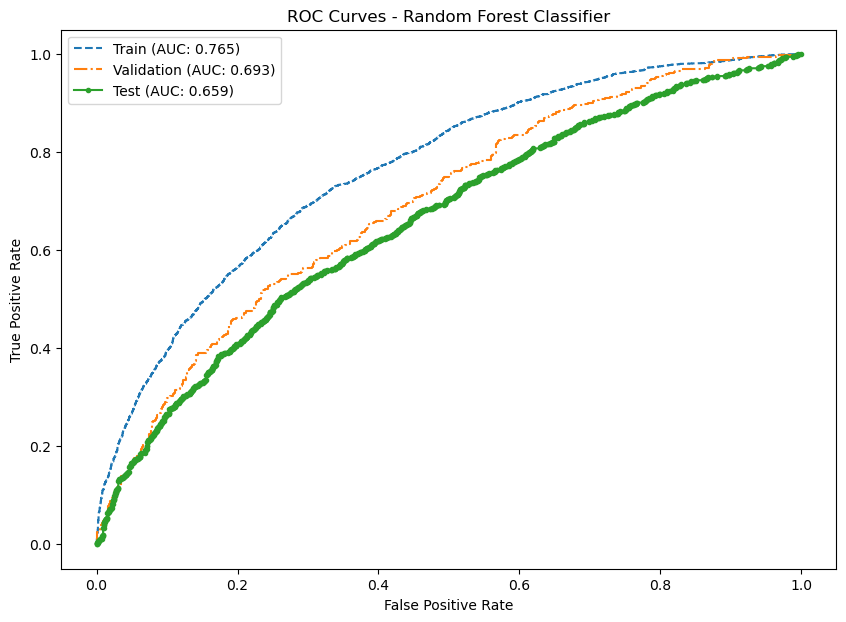

RANDOM FOREST - CLASSIFICATION EVALUATION

ROC AUC Scores
Train ROC AUC:       0.765
Validation ROC AUC:  0.693
Test ROC AUC:        0.659

Accuracy
Train Accuracy:      0.695
Validation Accuracy: 0.636
Test Accuracy:       0.622

Precision
Train Precision:     0.691
Validation Precision:0.505
Test Precision:      0.504

Recall
Train Recall:        0.705
Validation Recall:   0.609
Test Recall:         0.581

F1 Score
Train F1 Score:      0.698
Validation F1 Score: 0.552
Test F1 Score:       0.539


In [127]:
classification_evaluation_rf(mRF_best, xRF_train, yRF_train, xRF_validation, yRF_validation, 
                             xRF_test, yRF_test, threshold=0.5)

## Logistic Regression

In [111]:
from sklearn.model_selection import train_test_split
#Split the data into temp and test sets
temp_df, train_df = train_test_split(flight_df, test_size=0.6, random_state=42)

#Split the data into train and validation sets
test_df, validation_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {train_df.shape}, Validation: {validation_df.shape}, Test: {test_df.shape}")

Train: (5927, 19), Validation: (1976, 19), Test: (1975, 19)


In [112]:
from sklearn.model_selection import train_test_split

X_train = train_df.drop("flight_delayed", axis=1)
y_train = train_df["flight_delayed"]

X_validation = validation_df.drop("flight_delayed", axis=1)
y_validation = validation_df["flight_delayed"]

X_test = test_df.drop("flight_delayed", axis=1)
y_test = test_df["flight_delayed"]

from sklearn.preprocessing import LabelEncoder
categorical_cols = ['op_unique_carrier', 'origin', 'dest']

for col in categorical_cols:
    all_values = pd.concat([X_train[col], X_validation[col], X_test[col]]).astype(str)
    le = LabelEncoder()
    le.fit(all_values)

    X_train[col] = le.transform(X_train[col].astype(str))
    X_validation[col] = le.transform(X_validation[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

columns_to_drop = ['fl_date', 'origin_city_name', 'origin_state_nm',
                   'dest_city_name', 'dest_state_nm','dep_delay',
                   'crs_dep_time','op_carrier_fl_num']

X_train = X_train.drop(columns_to_drop, axis=1)
X_validation = X_validation.drop(columns_to_drop, axis=1)
X_test = X_test.drop(columns_to_drop, axis=1)

In [113]:
import statsmodels.formula.api as smf

formula = "flight_delayed ~ distance + month + day_of_week + op_unique_carrier+ dep_time"

logit_model = smf.logit(formula=formula, data=train_df).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.619452
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         flight_delayed   No. Observations:                 5927
Model:                          Logit   Df Residuals:                     5908
Method:                           MLE   Df Model:                           18
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                 0.06796
Time:                        21:36:01   Log-Likelihood:                -3671.5
converged:                       True   LL-Null:                       -3939.2
Covariance Type:            nonrobust   LLR p-value:                3.698e-102
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.9406      0.233    -12.601      0.000      -3.398   

In [114]:
import numpy as np

# Predict probability of delay for each row in the training set using a 0.5 cutoff
train_df['Predicted_Prob'] = logit_model.predict(train_df)
# (>= 0.5 → predicted delayed, < 0.5 → predicted not delayed)
train_df['Predicted_Class'] = np.where(train_df['Predicted_Prob'] >= 0.5, 1, 0)
print(train_df[['flight_delayed', 'Predicted_Prob', 'Predicted_Class']].head(15))


      flight_delayed  Predicted_Prob  Predicted_Class
7098               0        0.125317                0
1982               0        0.304913                0
4080               0        0.223398                0
2849               0        0.275127                0
8961               1        0.292293                0
6386               0        0.257042                0
4020               0        0.318017                0
5208               1        0.522965                1
6211               0        0.623206                1
935                0        0.556346                1
107                1        0.395015                0
3719               0        0.375960                0
2756               0        0.322027                0
1228               1        0.584527                1
4869               1        0.455833                0


### Backward

In [115]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=2000)
sfs = SFS(lr,
          k_features = 3, 
          forward = False, 
          floating = False, 
          verbose = 2,
          scoring = 'accuracy',
          cv = 4)

sfs = sfs.fit(X_train, y_train)

# Results table
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_df
print("Selected features: ", sfs.k_feature_names_)


[2025-11-29 21:36:41] Features: 9/3 -- score: 0.6468697974615029
[2025-11-29 21:36:42] Features: 8/3 -- score: 0.6468697974615029
[2025-11-29 21:36:42] Features: 7/3 -- score: 0.6468697974615029
[2025-11-29 21:36:43] Features: 6/3 -- score: 0.6467011065033383
[2025-11-29 21:36:43] Features: 5/3 -- score: 0.6455204976030166
[2025-11-29 21:36:43] Features: 4/3 -- score: 0.6451831156866872

Selected features:  ('day_of_week', 'dep_time', 'distance')



[2025-11-29 21:36:43] Features: 3/3 -- score: 0.6431572295408963

In [125]:
selected_features = ['day_of_week', 'dep_time', 'distance'] 

X_train_sfs = X_train[selected_features]
X_validation_sfs = X_validation[selected_features]
X_test_sfs = X_test[selected_features]

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_sfs, y_train)

y_pred_val = lr.predict(X_validation_sfs)
y_pred_test = lr.predict(X_test_sfs)

# PROBABILITY predictions for AUC
val_prob = lr.predict_proba(X_validation_sfs)[:, 1]
test_prob = lr.predict_proba(X_test_sfs)[:, 1]


from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

sens_val = recall_score(y_validation, y_pred_val)
prec_val = precision_score(y_validation, y_pred_val)
acc_val = accuracy_score(y_validation, y_pred_val)
f1_val = f1_score(y_validation, y_pred_val)
auc_val = roc_auc_score(y_validation, val_prob)

sens_test = recall_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
acc_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, test_prob)


print("VALIDATION RESULTS (Backward Selection)")
print(f"Sensitivity (Recall): {sens_val:.3f}")
print(f"Precision:            {prec_val:.3f}")
print(f"Accuracy:             {acc_val:.3f}")
print(f"F1 Score:             {f1_val:.3f}")
print(f"AUC Score:            {auc_val:.3f}")

print("\nTEST RESULTS (Backward Selection)")
print(f"Sensitivity (Recall): {sens_test:.3f}")
print(f"Precision:            {prec_test:.3f}")
print(f"Accuracy:             {acc_test:.3f}")
print(f"F1 Score:             {f1_test:.3f}")
print(f"AUC Score:            {auc_test:.3f}")

VALIDATION RESULTS (Backward Selection)
Sensitivity (Recall): 0.302
Precision:            0.568
Accuracy:             0.669
F1 Score:             0.394
AUC Score:            0.668

TEST RESULTS (Backward Selection)
Sensitivity (Recall): 0.251
Precision:            0.543
Accuracy:             0.661
F1 Score:             0.343
AUC Score:            0.645


### Foward

In [123]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=2000)
sfs = SFS(lr,   
         k_features=3, 
          forward=True, 
          floating=False, 
          verbose=0,
          scoring='accuracy', 
          cv=4)
sfs = sfs.fit(X_train, y_train)

# Results table
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_df
print("Selected features: ", sfs.k_feature_names_)  

Selected features:  ('day_of_week', 'dep_time', 'distance')


In [124]:
selected_features_forward = ['day_of_week', 'dep_time', 'distance']  

X_train_sfs_f = X_train[selected_features_forward]
X_validation_sfs_f = X_validation[selected_features_forward]
X_test_sfs_f = X_test[selected_features_forward]

from sklearn.linear_model import LogisticRegression
lr_f = LogisticRegression(max_iter=2000)
lr_f.fit(X_train_sfs_f, y_train)

y_pred_val_f = lr_f.predict(X_validation_sfs_f)
y_pred_test_f = lr_f.predict(X_test_sfs_f)

val_prob_f = lr_f.predict_proba(X_validation_sfs_f)[:, 1]
test_prob_f = lr_f.predict_proba(X_test_sfs_f)[:, 1]

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

sens_val_f = recall_score(y_validation, y_pred_val_f)
prec_val_f = precision_score(y_validation, y_pred_val_f)
acc_val_f = accuracy_score(y_validation, y_pred_val_f)
f1_val_f = f1_score(y_validation, y_pred_val_f)
auc_val_f = roc_auc_score(y_validation, val_prob_f)

sens_test_f = recall_score(y_test, y_pred_test_f)
prec_test_f = precision_score(y_test, y_pred_test_f)
acc_test_f = accuracy_score(y_test, y_pred_test_f)
f1_test_f = f1_score(y_test, y_pred_test_f)
auc_test_f = roc_auc_score(y_test, test_prob_f)

print("FORWARD SELECTION — VALIDATION RESULTS")
print(f"Sensitivity (Recall): {sens_val_f:.3f}")
print(f"Precision:            {prec_val_f:.3f}")
print(f"Accuracy:             {acc_val_f:.3f}")
print(f"F1 Score:             {f1_val_f:.3f}")
print(f"AUC Score:            {auc_val_f:.3f}")

print("\nFORWARD SELECTION — TEST RESULTS")
print(f"Sensitivity (Recall): {sens_test_f:.3f}")
print(f"Precision:            {prec_test_f:.3f}")
print(f"Accuracy:             {acc_test_f:.3f}")
print(f"F1 Score:             {f1_test_f:.3f}")
print(f"AUC Score:            {auc_test_f:.3f}")

FORWARD SELECTION — VALIDATION RESULTS
Sensitivity (Recall): 0.302
Precision:            0.568
Accuracy:             0.669
F1 Score:             0.394
AUC Score:            0.668

FORWARD SELECTION — TEST RESULTS
Sensitivity (Recall): 0.251
Precision:            0.543
Accuracy:             0.661
F1 Score:             0.343
AUC Score:            0.645


### Stepwise

In [119]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=2000)
sfs = SFS(lr,   
       k_features=3, 
          forward=True, 
          floating=False, 
          verbose=0,
          scoring='accuracy',
          cv=4)
sfs = sfs.fit(X_train, y_train)

# Results table
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_df
print("Selected features: ", sfs.k_feature_names_) 

Selected features:  ('day_of_week', 'dep_time', 'distance')


In [120]:
selected_features_stepwise = ['day_of_week', 'dep_time', 'distance']  

X_train_sfs_step = X_train[selected_features_stepwise]
X_validation_sfs_step = X_validation[selected_features_stepwise]
X_test_sfs_step = X_test[selected_features_stepwise]

from sklearn.linear_model import LogisticRegression
lr_step = LogisticRegression(max_iter=2000)
lr_step.fit(X_train_sfs_step, y_train)

y_pred_val_step = lr_step.predict(X_validation_sfs_step)
y_pred_test_step = lr_step.predict(X_test_sfs_step)

# PROBABILITY predictions for AUC
val_prob_step = lr_step.predict_proba(X_validation_sfs_step)[:, 1]
test_prob_step = lr_step.predict_proba(X_test_sfs_step)[:, 1]

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

sens_val_step = recall_score(y_validation, y_pred_val_step)
prec_val_step = precision_score(y_validation, y_pred_val_step)
acc_val_step = accuracy_score(y_validation, y_pred_val_step)
f1_val_step = f1_score(y_validation, y_pred_val_step)
auc_val_step = roc_auc_score(y_validation, val_prob_step)

sens_test_step = recall_score(y_test, y_pred_test_step)
prec_test_step = precision_score(y_test, y_pred_test_step)
acc_test_step = accuracy_score(y_test, y_pred_test_step)
f1_test_step = f1_score(y_test, y_pred_test_step)
auc_test_step = roc_auc_score(y_test, test_prob_step)

print("STEPWISE SELECTION — VALIDATION RESULTS")
print(f"Sensitivity (Recall): {sens_val_step:.3f}")
print(f"Precision:            {prec_val_step:.3f}")
print(f"Accuracy:             {acc_val_step:.3f}")
print(f"F1 Score:             {f1_val_step:.3f}")
print(f"AUC Score:            {auc_val_step:.3f}")

print("\nSTEPWISE SELECTION — TEST RESULTS")
print(f"Sensitivity (Recall): {sens_test_step:.3f}")
print(f"Precision:            {prec_test_step:.3f}")
print(f"Accuracy:             {acc_test_step:.3f}")
print(f"F1 Score:             {f1_test_step:.3f}")
print(f"AUC Score:            {auc_test_step:.3f}")

STEPWISE SELECTION — VALIDATION RESULTS
Sensitivity (Recall): 0.302
Precision:            0.568
Accuracy:             0.669
F1 Score:             0.394
AUC Score:            0.668

STEPWISE SELECTION — TEST RESULTS
Sensitivity (Recall): 0.251
Precision:            0.543
Accuracy:             0.661
F1 Score:             0.343
AUC Score:            0.645


## KNN

In [36]:
print(flight_df.shape)
# Display the first few rows of the DataFrame
flight_df.head()

(9878, 19)


,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,dest,dest_city_name,dest_state_nm,crs_dep_time,dep_time,dep_delay,cancelled,distance,flight_delayed
0,2024,4,18,4,2024-04-18,MQ,3535.0,DFW,"Dallas/Fort Worth, TX",Texas,RAP,"Rapid City, SD",South Dakota,1018,1015.0,-3.0,0,835.0,0
1,2024,1,1,1,2024-01-01,AA,148.0,CLT,"Charlotte, NC",North Carolina,PHX,"Phoenix, AZ",Arizona,1637,1633.0,-4.0,0,1773.0,0
2,2024,12,12,4,2024-12-12,9E,5440.0,CHA,"Chattanooga, TN",Tennessee,ATL,"Atlanta, GA",Georgia,1000,952.0,-8.0,0,106.0,0
3,2024,4,8,1,2024-04-08,WN,1971.0,OMA,"Omaha, NE",Nebraska,LAS,"Las Vegas, NV",Nevada,1330,1334.0,4.0,0,1099.0,1
4,2024,2,16,5,2024-02-16,WN,862.0,BWI,"Baltimore, MD",Maryland,MYR,"Myrtle Beach, SC",South Carolina,1340,1333.0,-7.0,0,399.0,0


<function matplotlib.pyplot.show(close=None, block=None)>

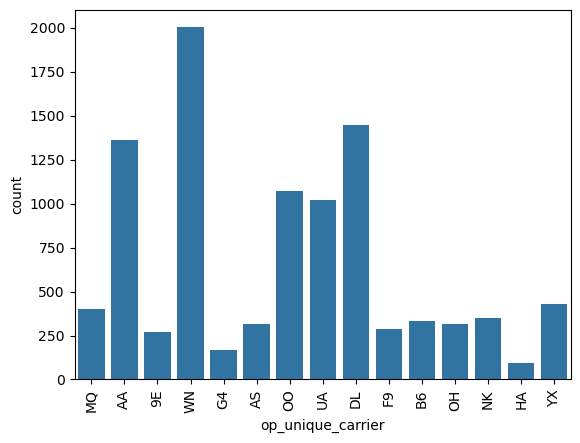

In [37]:
# count plot of the op_unique_carrier
sns.countplot(data=flight_df, x="op_unique_carrier")
plt.xticks(rotation=90)
plt.show

In [94]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score, 
                             precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report)
from imblearn.combine import SMOTETomek
import random

# Select relevant columns (excluding dep_delay for prediction)
features = [
    'year', 'month', 'day_of_month', 'day_of_week', 'op_unique_carrier',
    'origin', 'dest', 'distance', 'dep_time'
]
X = flight_df[features].copy()
y = flight_df['flight_delayed'].copy()

In [95]:
# Encode categorical variables
X = pd.get_dummies(X, columns=['op_unique_carrier', 'origin', 'dest'], drop_first=True)

print(f"Features shape after encoding: {X.shape}")

# Split into train/test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(
    X_temp, y_temp, test_size=0.625, random_state=42)

print(f"Train: {X_train.shape}, Validation: {X_validation.shape}, Test: {X_test.shape}")
# Rename for consistency with other models
xKNN_train = X_train.copy()
yKNN_train = y_train.copy()
xKNN_validation = X_validation.copy()
yKNN_validation = y_validation.copy()
xKNN_test = X_test.copy()
yKNN_test = y_test.copy()

smotetomek = SMOTETomek(random_state=42)
xKNN_train, yKNN_train = smotetomek.fit_resample(xKNN_train, yKNN_train)

print(f"\nAfter SMOTETomek:")
print(f"Training set class distribution:\n{yKNN_train.value_counts()}")
print(f"Validation set class distribution:\n{yKNN_validation.value_counts()}")
print(f"Test set class distribution:\n{yKNN_test.value_counts()}")

# Scale Features
scaler = StandardScaler()
xKNN_train_scaled = scaler.fit_transform(xKNN_train)
xKNN_validation_scaled = scaler.transform(xKNN_validation)
xKNN_test_scaled = scaler.transform(xKNN_test)

print(f"\nFeatures scaled successfully")

Features shape after encoding: (9878, 587)
Train: (5926, 587), Validation: (1482, 587), Test: (2470, 587)

After SMOTETomek:
Training set class distribution:
flight_delayed
0    3266
1    3266
Name: count, dtype: int64
Validation set class distribution:
flight_delayed
0    935
1    547
Name: count, dtype: int64
Test set class distribution:
flight_delayed
0    1528
1     942
Name: count, dtype: int64

Features scaled successfully


### Fit KNN Model and Evaluate

In [96]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_score, recall_score, f1_score
)
# Define the model
knn = KNeighborsClassifier()

# Define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Evaluate the model using cross-validation
scores = cross_val_score(knn, xKNN_train_scaled, yKNN_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print(f'\nCross-Validation Mean ROC AUC: {np.mean(scores):.3f} (std: {np.std(scores):.3f})')



Cross-Validation Mean ROC AUC: 0.642 (std: 0.020)


In [97]:
# Fit the model
mKNN_best = KNeighborsClassifier(n_neighbors=5, algorithm='auto', n_jobs=-1)
mKNN_best.fit(xKNN_train_scaled, yKNN_train)

print("\nKNN model trained with default parameters (n_neighbors=5)")

train_pred = mKNN_best.predict_proba(xKNN_train_scaled)[:, 1]
validation_pred = mKNN_best.predict_proba(xKNN_validation_scaled)[:, 1]
test_pred = mKNN_best.predict_proba(xKNN_test_scaled)[:, 1]


KNN model trained with default parameters (n_neighbors=5)


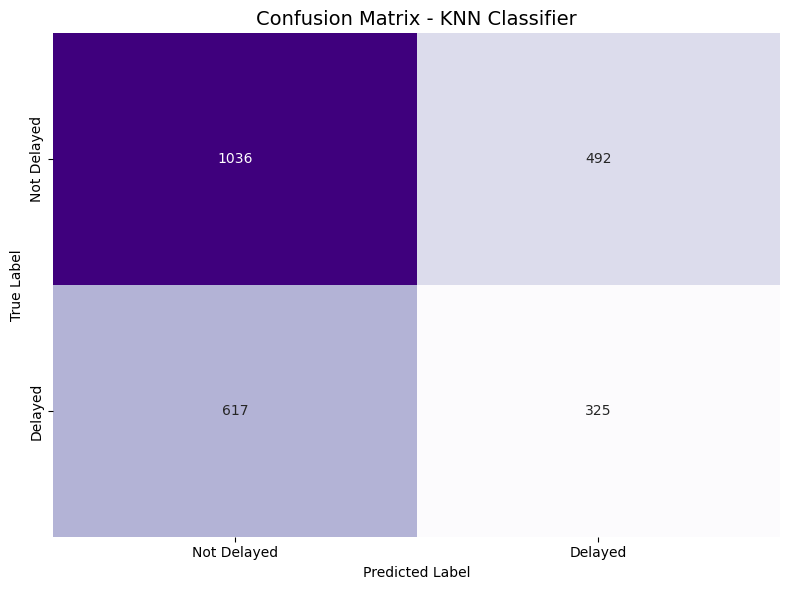


Classification Report (Test Set):
              precision    recall  f1-score   support

 Not Delayed       0.63      0.68      0.65      1528
     Delayed       0.40      0.35      0.37       942

    accuracy                           0.55      2470
   macro avg       0.51      0.51      0.51      2470
weighted avg       0.54      0.55      0.54      2470



In [98]:
y_pred_test_binary = (test_pred > 0.5).astype(int)

cm = confusion_matrix(yKNN_test, y_pred_test_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['Not Delayed', 'Delayed'],
            yticklabels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix - KNN Classifier', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\nClassification Report (Test Set):")
print(classification_report(yKNN_test, y_pred_test_binary, target_names=['Not Delayed', 'Delayed']))


In [128]:
# define a classification_evaluation function(model, X_train, y_train, X_test, y_test, threshold=0.5):
def classification_evaluation_knn(model, X_train, y_train, X_validation, y_validation, 
                                  X_test, y_test, threshold=0.5):

#Evaluate KNN model on train, validation, and test sets.
    
    train_pred = model.predict_proba(X_train)[:, 1]
    validation_pred = model.predict_proba(X_validation)[:, 1]
    test_pred = model.predict_proba(X_test)[:, 1]
    
    # ROC AUC Scores
    train_auc = roc_auc_score(y_train, train_pred)
    validation_auc = roc_auc_score(y_validation, validation_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    
    # ROC Curves
    fpr_train, tpr_train, _ = roc_curve(y_train, train_pred)
    fpr_validation, tpr_validation, _ = roc_curve(y_validation, validation_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, test_pred)

    # Plot ROC Curves
    plt.figure(figsize=(10, 7))
    plt.plot(fpr_train, tpr_train, linestyle='--', label=f'Train (AUC: {train_auc:.3f})')
    plt.plot(fpr_validation, tpr_validation, linestyle='-.', label=f'Validation (AUC: {validation_auc:.3f})')
    plt.plot(fpr_test, tpr_test, marker='.', label=f'Test (AUC: {test_auc:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - KNN Classifier')
    plt.legend()
    plt.show()

    # Convert probabilities to binary predictions
    train_pred_binary = (train_pred > threshold).astype(int)
    validation_pred_binary = (validation_pred > threshold).astype(int)
    test_pred_binary = (test_pred > threshold).astype(int)

    # Print Metrics
    print("KNN - CLASSIFICATION EVALUATION")

    print("\nROC AUC Scores")
    print(f"Train ROC AUC:       {train_auc:.3f}")
    print(f"Validation ROC AUC:  {validation_auc:.3f}")
    print(f"Test ROC AUC:        {test_auc:.3f}")
    
    print("\nAccuracy")
    print(f"Train Accuracy:      {accuracy_score(y_train, train_pred_binary):.3f}")
    print(f"Validation Accuracy: {accuracy_score(y_validation, validation_pred_binary):.3f}")
    print(f"Test Accuracy:       {accuracy_score(y_test, test_pred_binary):.3f}")
    
    print("\nPrecision")
    print(f"Train Precision:     {precision_score(y_train, train_pred_binary):.3f}")
    print(f"Validation Precision:{precision_score(y_validation, validation_pred_binary):.3f}")
    print(f"Test Precision:      {precision_score(y_test, test_pred_binary):.3f}")
    
    print("\nRecall")
    print(f"Train Recall:        {recall_score(y_train, train_pred_binary):.3f}")
    print(f"Validation Recall:   {recall_score(y_validation, validation_pred_binary):.3f}")
    print(f"Test Recall:         {recall_score(y_test, test_pred_binary):.3f}")
    
    print("\nF1 Score")
    print(f"Train F1 Score:      {f1_score(y_train, train_pred_binary):.3f}")
    print(f"Validation F1 Score: {f1_score(y_validation, validation_pred_binary):.3f}")
    print(f"Test F1 Score:       {f1_score(y_test, test_pred_binary):.3f}")


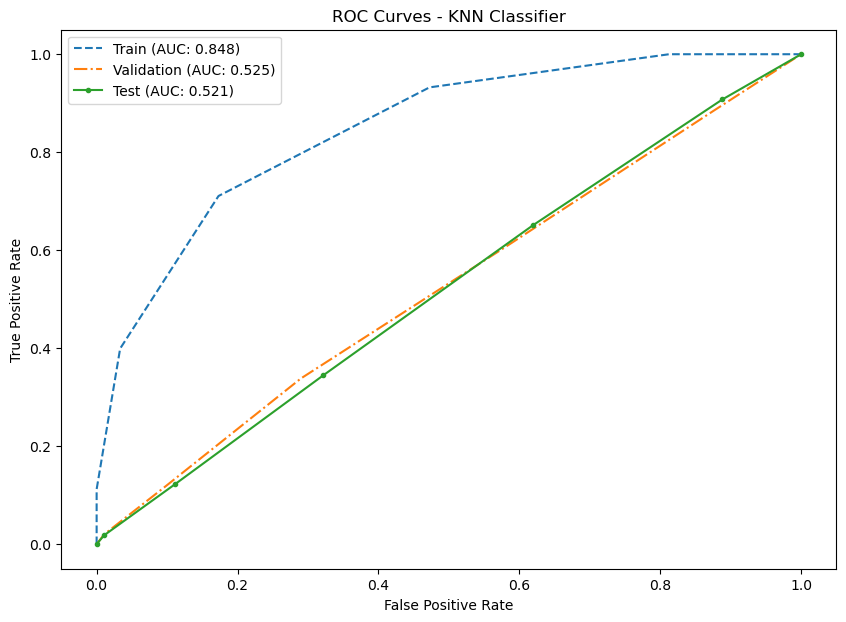

KNN - CLASSIFICATION EVALUATION

ROC AUC Scores
Train ROC AUC:       0.848
Validation ROC AUC:  0.525
Test ROC AUC:        0.521

Accuracy
Train Accuracy:      0.769
Validation Accuracy: 0.573
Test Accuracy:       0.551

Precision
Train Precision:     0.804
Validation Precision:0.406
Test Precision:      0.398

Recall
Train Recall:        0.711
Validation Recall:   0.338
Test Recall:         0.345

F1 Score
Train F1 Score:      0.755
Validation F1 Score: 0.369
Test F1 Score:       0.370


In [129]:
classification_evaluation_knn(mKNN_best, xKNN_train_scaled, yKNN_train, 
                              xKNN_validation_scaled, yKNN_validation, 
                              xKNN_test_scaled, yKNN_test, threshold=0.5)
